In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Datasets/

/content/drive/MyDrive/Datasets


In [ ]:
ls

0models.pth.tar           2_uncased_models.pth.tar  Task1/
0_uncased_models.pth.tar  3models.pth.tar           Task2/
1models.pth.tar           3_uncased_models.pth.tar  test_1.csv
1_uncased_models.pth.tar  Bert_case/                test_1_old.csv
2models.pth.tar           file_1.csv                test-2-aila-task1-2021/


In [ ]:
! pip install transformers==4.10.3
# ! pip install neptune-client

### New section1

In [ ]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import numpy as np
import torch
import torch.nn as nn
import time
import datetime
import random
import os
import os.path
from sklearn import metrics
load_model = False
save_model = False

if load_model:
    output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin"
    output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin"
    output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin"


In [ ]:

import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import numpy as np
import torch
import torch.nn as nn
import time
import datetime
import random
import os
import os.path
from sklearn import metrics
# import neptune
load_model = False
save_model = True

if load_model:
    output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin"
    output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin"
    output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin"


In [ ]:

data = pd.read_csv("/content/drive/MyDrive/Datasets/file_1.csv", delimiter=',')


In [ ]:
data

,sent,label,dataset
0,"One Lakshminarayana Iyer, a Hindu Brahmin, who...",Facts,d_1
1,Ramalakshmi had married the plaintiff and had ...,Facts,d_1
2,"They were all alive in December, 1924, when La...",Facts,d_1
3,Before his death he executed a will on 16th No...,Ratio of the decision,d_1
4,By this will he gave the following directions ...,Facts,d_1
...,...,...,...
11280,In these circumstances it would be fair and pr...,Ratio of the decision,d_9
11281,If and when he prefers a claim to this particu...,Ratio of the decision,d_9
11282,"In this view of the matter,we feel that the Hi...",Ratio of the decision,d_9
11283,"The appeal is,therefore,dismissed with costs",Ruling by Present Court,d_9


In [ ]:
data.label.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: label, dtype: int64

In [ ]:

data.label = data.label.str.replace('Ratio of the decision','0')
data.label = data.label.str.replace('Facts','1')
data.label = data.label.str.replace('Precedent','2')
data.label = data.label.str.replace('Argument','3')
data.label = data.label.str.replace('Statute','4')
data.label = data.label.str.replace('Ruling by Lower Court','5')
data.label = data.label.str.replace('Ruling by Present Court','6')
data.label = data.label.astype(int)
df2 = data.copy()
df = df2.sample(frac=0.8, random_state=0)
dev_df = df2.drop(df.index)

In [ ]:
df2 = data.copy()
df = df2.sample(frac=0.8, random_state=0)
dev_df = df2.drop(df.index)

In [ ]:
#1 df.head()
data.head()
import matplotlib.pyplot as plt


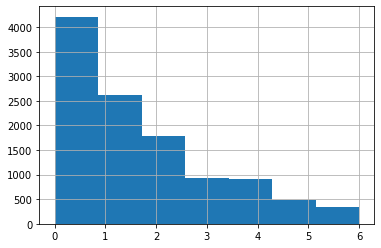

In [ ]:
import matplotlib.pyplot as plt

data.label.hist(bins= 7)

In [ ]:
data['label'].value_counts(normalize=True) * 100

0    37.315020
1    23.234382
2    15.835179
3     8.320780
4     7.992911
5     4.280018
6     3.021710
Name: label, dtype: float64

In [ ]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))


Number of training sentences: 9,028



In [ ]:
df

,sent,label,dataset
4136,"Resultantly,the appeal being devoid of any mer...",0,d_29
5457,It claimed user of the said mark since 1963 an...,1,d_37
10555,"In the present facts and circumstances, even t...",0,d_58
3701,"On the other hand, the contention of the Custo...",3,d_27
9595,Bye-Law No.4 prescribes the total share capita...,0,d_55
...,...,...,...
7858,Appeals allowed,6,d_45
3298,The respondent workers cannot be held to hold ...,2,d_25
3372,"The Additional Sessions Judge,New Delhi also i...",1,d_26
7954,All the expressions used under this section ar...,0,d_46


In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sent.values
labels = df.label.values
labels

array([0, 1, 0, ..., 1, 0, 5])

In [ ]:
# Get the lists of sentences and their labels.
dev_sentences = dev_df.sent.values
dev_labels = dev_df.label.values

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
if load_model:
    tokenizer = BertTokenizer.from_pretrained(output_vocab_file, do_lower_case = True)
else:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
dev_input_ids = []
.
for sent in sentences:
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    input_ids.append(encoded_sent)
for sent in dev_sentences:
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    dev_input_ids.append(encoded_sent)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
l = [len(x) for x in input_ids]

In [ ]:
np.quantile(l, 0.98)

111.45999999999913

(array([6.130e+03, 2.326e+03, 4.180e+02, 9.900e+01, 2.500e+01, 1.500e+01,
        5.000e+00, 5.000e+00, 3.000e+00, 2.000e+00]),
 array([  3. ,  41.2,  79.4, 117.6, 155.8, 194. , 232.2, 270.4, 308.6,
        346.8, 385. ]),
 <a list of 10 Patch objects>)

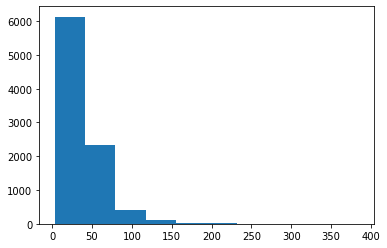

In [ ]:
np.histogram(l)
plt.hist(l)

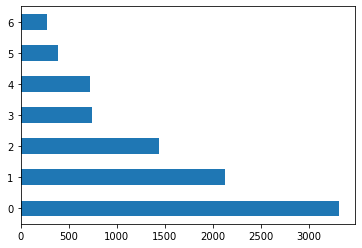

In [ ]:
df['label'].value_counts()[:].plot(kind='barh')

Test Function

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Datasets/test_1.csv", delimiter=',')

In [ ]:
test_df

,sent,label,dataset
0,"This appeal, by special leave, by the appellan...",Ratio of the decision,d1
1,The respondent was appointed by an order of th...,Facts,d1
2,The category of the post to which she was appo...,Facts,d1
3,"By an order dated February 16, 1967 of the Dep...",Facts,d1
4,The respondent filed Civil Rule no. 206 of 196...,Facts,d1
...,...,...,...
692,"Further, in various pleadings in the Title Sui...",Ratio of the decision,d9
693,"From these facts, it is clear that the respond...",Ratio of the decision,d9
694,"In view of the foregoing discussion, we do not...",Ruling by Present Court,d9
695,"However, the parties are left to bear their ow...",Ruling by Present Court,d9


In [ ]:
#func_call_test(1)

Train

In [ ]:

MAX_LEN = 120

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

dev_input_ids = pad_sequences(dev_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


pad_token = tokenizer.pad_token_id
# Create attention masks
attention_masks = []
dev_attention_masks = []

# For each sentence...
for sent in input_ids:
    att_mask = [int(token_id != pad_token) for token_id in sent]
    
    attention_masks.append(att_mask)

for sent in dev_input_ids:
    
    att_mask = [int(token_id != pad_token) for token_id in sent]
    dev_attention_masks.append(att_mask)
    

train_inputs = input_ids 
validation_inputs = dev_input_ids
train_labels = labels
validation_labels = dev_labels

# Do the same for the masks.
train_masks =  attention_masks
validation_masks = dev_attention_masks
                                             
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)

train_labels = torch.tensor(train_labels).to(torch.int64)
validation_labels = torch.tensor(validation_labels).to(torch.int64)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

if load_model:
    config = BertConfig.from_json_file(output_config_file)
    model = BertForSequenceClassification(config)
    state_dict = torch.load(output_model_file)
    model.load_state_dict(state_dict)

else: 
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", 
        num_labels = 7,    
        output_attentions = False,
        output_hidden_states = False,
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)


params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    
learning_rate = 2e-5
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
use_neptune = 1                                            
if use_neptune:
    api = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NDRkYTliMS1lZGRjLTRhOWMtOGU0ZC04OTEzNzU1Y2E2Y2MifQ=="
    neptune.init(project_qualified_name='hnlp.hasoc/nlp', api_token=api)
    PARAMS = {'lr': learning_rate,}
    tags = ['bert']
    neptune.create_experiment("First_exp", tags=tags, params=PARAMS)
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
    

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([341, 483, 902, 939, 1787, 2622, 4211]).to(device))
for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()
    train_loss = []
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask)
        logits = outputs[0]
        loss = criterion(logits,b_labels)
        total_loss += loss.item()
        neptune.log_metric("Loss_Train",loss.item())
        loss.backward()
        train_loss.append(loss.item())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)

    print("")
    #print("  training loss: {0:.2f}".format(train_loss))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    print("")
    print("Running Validation...")
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions = []
    true_labels = []
    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        ##
        predictions.append(logits)
        true_labels.append(label_ids)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1
        neptune.log_metric("Acc_Val",tmp_eval_accuracy)
    
        # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

        # Combine the correct labels for each batch into a single list.
    flat_true_labels = [item for sublist in true_labels for item in sublist]
        
    def evaluate(y_true, y_pred):
    
        assert len(y_true) == len(y_pred)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
        scores = [
            "F1: %f\n" % f1,
            "Recall: %f\n" % recall,
            "Precision: %f\n" % precision,
            "ExactMatch: %f\n" % -1.0
        ]
        for s in scores:
            print(s, end='')
        # Evaluate predictions    
    evaluate(flat_true_labels, flat_predictions)
    # Calculate the accuracy for this batch of test sentences.
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    
    torch.save(model, "/content/drive/MyDrive/Datasets/"+str(epoch_i)+"_uncased_models.pth.tar")
    # func_call_test(epoch_i)
print("")
print("Training complete!")



Padding/truncating all sentences to 120 values...

Padding token: "[PAD]", ID: 0

Done.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias          

ERROR:neptune.internal.threads.ping_thread:Unexpected error in ping thread.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 392, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/usr/local/lib/python3.7/dist-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/usr/local/lib/python3.7/dist-packages/six.py", line 703, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/usr/local/lib/python3.7/dist-packages/bravado/http_future.py", line 124,

  Batch 1,120  of  1,129.    Elapsed: 0:07:40.

  Average training loss: 0.94
  Training epcoh took: 0:07:44

Running Validation...
F1: 0.638821
Recall: 0.617668
Precision: 0.668917
ExactMatch: -1.000000
  Accuracy: 0.61
  Validation took: 0:08:21

======== Epoch 3 / 4 ========
Training...
  Batch    40  of  1,129.    Elapsed: 0:00:17.
  Batch    80  of  1,129.    Elapsed: 0:00:33.
  Batch   120  of  1,129.    Elapsed: 0:00:50.
  Batch   160  of  1,129.    Elapsed: 0:01:06.
  Batch   200  of  1,129.    Elapsed: 0:01:22.
  Batch   240  of  1,129.    Elapsed: 0:01:39.
  Batch   280  of  1,129.    Elapsed: 0:01:55.
  Batch   320  of  1,129.    Elapsed: 0:02:12.
  Batch   360  of  1,129.    Elapsed: 0:02:28.
  Batch   400  of  1,129.    Elapsed: 0:02:44.
  Batch   440  of  1,129.    Elapsed: 0:03:01.
  Batch   480  of  1,129.    Elapsed: 0:03:17.
  Batch   520  of  1,129.    Elapsed: 0:03:34.
  Batch   560  of  1,129.    Elapsed: 0:03:50.
  Batch   600  of  1,129.    Elapsed: 0:04:06.
  Ba

In [ ]:

MAX_LEN = 120
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case= False)
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.

model = BertForSequenceClassification.from_pretrained(
        "bert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 7, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.cuda()
print(device)


Padding/truncating all sentences to 120 values...

Padding token: "[PAD]", ID: 0


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

cuda


In [ ]:
model = torch.load("/content/drive/MyDrive/Datasets/Bert_case/3models.pth.tar")
# model = torch.load("/content/drive/MyDrive/Datasets/3_uncased_models.pth.tar")
model = model.to(device)

In [ ]:
data.label = data.label.str.replace('Ratio of the decision','0')
data.label = data.label.str.replace('Facts','1')
data.label = data.label.str.replace('Precedent','2')
data.label = data.label.str.replace('Argument','3')
data.label = data.label.str.replace('Statute','4')
data.label = data.label.str.replace('Ruling by Lower Court','5')
data.label = data.label.str.replace('Ruling by Present Court','6')
data.label = data.label.astype(int)

In [ ]:
diction = {0:'Ratio of the decision',1:'Facts',2:'Precedent',3:'Argument',4:'Statute',5:'Ruling by Lower Court',6:'Ruling by Present Court'}

In [ ]:
# model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask)

In [ ]:

def func_call_test(epoch_id):
    model.eval()
    test_df = pd.read_csv("/content/drive/MyDrive/Datasets/test_1.csv", delimiter=',')
    test_sentences = test_df.sent.values
    test_labels = test_df.label.values
    print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))
    test_input_ids = []

    # For every sentence...
    for sent in test_sentences:
        encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
        
        test_input_ids.append(encoded_sent)

    # Pad our input tokens
    test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                              dtype="long", truncating="post", padding="post")
    pad_token = tokenizer.pad_token_id
    # Create attention masks
    test_attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in test_input_ids:
      seq_mask = [int(i != pad_token) for i in seq]
      test_attention_masks.append(seq_mask) 

    # Convert to tensors.
    prediction_inputs = torch.tensor(test_input_ids).to(torch.int64)
    prediction_masks = torch.tensor(test_attention_masks)
    prediction_labels = torch.zeros(len(test_labels)).to(torch.int64)

    # Set the batch size.  
    batch_size = 32  

    # Create the DataLoader.
    prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    # Prediction on test set

    print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels = [], []
   
    # Predict 
    for batch in prediction_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

    print('    DONE.')

    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    return flat_predictions
    print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))
    with open('/content/drive/MyDrive/Datasets/predictionstrue1_1b_bbert.csv', "w") as writer:
        for i,line in enumerate(predictions):
            writer.write(str(line) +" " +str(true_labels[i]) + "\n")
      
    # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    print(flat_predictions)
    # Combine the correct labels for each batch into a single list.
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    def evaluate(y_true, y_pred):
        """
        Evaluate Precision, Recall, F1 scores between y_true and y_pred
        If output_file is provided, scores are saved in this file otherwise printed to std output.
        :param y_true: true labels
        :param y_pred: predicted labels
        :return: list of scores (F1, Recall, Precision, ExactMatch)
        """
        
        assert len(y_true) == len(y_pred)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
        scores = [
            "F1: %f\n" % f1,
            "Recall: %f\n" % recall,
            "Precision: %f\n" % precision,
            "ExactMatch: %f\n" % -1.0
        ]
        for s in scores:
            print(s, end='')

    # Evaluate predictions    
    evaluate(flat_true_labels, flat_predictions)

    print('Writing predictions to file...')
    with open("/content/drive/MyDrive/Datasets/statout_1b_Bbert"+str(epoch_i)+".csv", "w") as writer:
      for line in flat_predictions:
            writer.write(str(line) + "\n")
    #//Check this    
   #// You had to interchange these two
    # Save predictions to file
    with open('/content/drive/MyDrive/Datasets/predictions1_1b_Bbert.csv', "w") as writer:
        for line in flat_predictions:
            writer.write(str(line) + "\n")
            
    print('Done writing predictions...')


    if(save_model):
        v = 0
        folder_name = "Bert-large-cased-" + str(v)
        if(os.path.exists(folder_name)):
            v+=1
            folder_name = "Bert-large-uncased-" + str(v)
        else:
            os.mkdir(folder_name)
        output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin".format(model)
        output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin".format(model)
        output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin".format(model)

        model_to_save = model.module if hasattr(model, 'module') else model

        torch.save(model_to_save.state_dict(), output_model_file)
        model_to_save.config.to_json_file(output_config_file)
        tokenizer.save_vocabulary(output_vocab_file)

In [ ]:
preds = func_call_test(1)

Number of test sentences: 848

Predicting labels for 848 test sentences...
    DONE.


In [ ]:
preds

array([1, 1, 2, 2, 6, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 4, 4, 3, 0, 0, 2, 2,
       2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 5, 1, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 2, 6, 5, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 5, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3,
       3, 1, 1, 1, 1, 1, 1, 0, 4, 4, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 3, 3, 1, 0, 0, 2, 2, 0, 0, 1, 0, 0,
       0, 3, 0, 1, 0, 1, 1, 0, 6, 6, 1, 5, 1, 6, 6, 1, 6, 1, 2, 2, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 2, 4, 0, 0, 0, 2, 0, 4, 4, 2, 1, 1,
       2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 3, 0, 0, 2, 2, 0,
       2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1, 5,
       1, 3, 2, 1, 1, 1, 0, 2, 1, 2, 2, 0, 0, 6, 2,

In [ ]:
preds2 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 3, 0, 3, 0, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 6, 0, 6, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 3, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 3, 3, 3, 1, 3, 0, 0,
       0, 4, 4, 4, 4, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 1, 0, 3, 0, 0, 0, 2, 3,
       2, 2, 3, 2, 0, 2, 0, 2, 0, 0, 3, 0, 0, 0, 6, 6, 6, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 4, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 1, 0, 0, 6, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 2, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 4, 4, 1, 2, 1, 1, 1, 4, 4, 1, 0, 0, 1, 0, 6, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 1,
       1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 0, 2, 3, 3, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 4, 6, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 3,
       0, 0, 0, 0, 0, 0, 6, 0, 6, 1, 6, 6, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 6, 2, 0, 3, 0, 0, 3, 0, 0, 2, 2, 2, 0, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0,
       0, 2, 2, 0, 2, 2, 1, 1, 1, 0, 0, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2,
       0, 2, 0, 0, 1, 1, 3, 2, 0, 1, 2, 1, 1, 0, 3, 2, 2, 0, 1, 3, 0, 2,
       3, 0, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0,
       0, 0, 6, 0, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 3, 1, 3,
       3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 1, 4, 4, 4, 4, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 6])

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Datasets/test_1.csv", delimiter=',')

In [ ]:
values = test_df.dataset

In [ ]:
values

0      d1
1      d1
2      d1
3      d1
4      d1
       ..
692    d9
693    d9
694    d9
695    d9
696    d9
Name: dataset, Length: 697, dtype: object

In [ ]:
k = values.value_counts()

In [ ]:
k

d10    113
d9      98
d6      83
d8      79
d7      68
d2      64
d1      58
d3      49
d4      45
d5      40
Name: dataset, dtype: int64

In [ ]:
L = [107,86,108,54,105,70,60,45,105,108]

In [ ]:
K = []
for i in range(1,11):
  for j in range(1,L[i-1]+1):
    K.append(f'd{i}_s{j}')

In [ ]:
K

['d1_s1',
 'd1_s2',
 'd1_s3',
 'd1_s4',
 'd1_s5',
 'd1_s6',
 'd1_s7',
 'd1_s8',
 'd1_s9',
 'd1_s10',
 'd1_s11',
 'd1_s12',
 'd1_s13',
 'd1_s14',
 'd1_s15',
 'd1_s16',
 'd1_s17',
 'd1_s18',
 'd1_s19',
 'd1_s20',
 'd1_s21',
 'd1_s22',
 'd1_s23',
 'd1_s24',
 'd1_s25',
 'd1_s26',
 'd1_s27',
 'd1_s28',
 'd1_s29',
 'd1_s30',
 'd1_s31',
 'd1_s32',
 'd1_s33',
 'd1_s34',
 'd1_s35',
 'd1_s36',
 'd1_s37',
 'd1_s38',
 'd1_s39',
 'd1_s40',
 'd1_s41',
 'd1_s42',
 'd1_s43',
 'd1_s44',
 'd1_s45',
 'd1_s46',
 'd1_s47',
 'd1_s48',
 'd1_s49',
 'd1_s50',
 'd1_s51',
 'd1_s52',
 'd1_s53',
 'd1_s54',
 'd1_s55',
 'd1_s56',
 'd1_s57',
 'd1_s58',
 'd1_s59',
 'd1_s60',
 'd1_s61',
 'd1_s62',
 'd1_s63',
 'd1_s64',
 'd1_s65',
 'd1_s66',
 'd1_s67',
 'd1_s68',
 'd1_s69',
 'd1_s70',
 'd1_s71',
 'd1_s72',
 'd1_s73',
 'd1_s74',
 'd1_s75',
 'd1_s76',
 'd1_s77',
 'd1_s78',
 'd1_s79',
 'd1_s80',
 'd1_s81',
 'd1_s82',
 'd1_s83',
 'd1_s84',
 'd1_s85',
 'd1_s86',
 'd1_s87',
 'd1_s88',
 'd1_s89',
 'd1_s90',
 'd1_s91',
 'd1_s92